# Session 2 - Predicting Hodge numbers

In this session we will predict cohomology dimensions of line and tangent bundle of Calabi Yau manifolds.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tfk = tf.keras

## Hodge numbers of CICYs

Several papers were investigating the hodge numbers of CICY 3-folds using various ML techniques. [First](https://arxiv.org/abs/1706.02714), a [bit](https://arxiv.org/pdf/1806.03121.pdf) [later](https://arxiv.org/pdf/1903.03113.pdf) and currently best performing [results](https://arxiv.org/pdf/2007.13379.pdf). An analysis for CICY 4-folds also [exists](https://arxiv.org/abs/2009.02544).

CICYs are defined via a configuration matrix describing polynomial constraints in a product of complex projective spaces:

$$
\mathcal{M} =  \left[
\begin{array}{c||ccc}
n_0 & p^0_1 & \cdots & p^0_{K} \\
\vdots & \vdots & \ddots & \vdots \\
n_r & p^{r}_1 & \cdots & p^{r}_K  \\
\end{array}
\right]^{h^{(1,1)},h^{(2,1)}}_{\chi}.
$$

Here are some benchmarks from the earlier papers:

 - train, test: 4:1
 - accuracy: 77 %

Can we beat this?

### Data preparation

we load the data from a modified version of the [cicylist](http://www-thphys.physics.ox.ac.uk/projects/CalabiYau/cicylist/). The plain text file is a bit of a hassle to read in. It's easiest to load it with Mathematica and then save it in normal .csv format. I'm not sure if I'm allowed to distribute this modified file, thus if you want to have it just send me a mail.

In [2]:
df = pd.read_csv('data/cicylist/cicylist_dict.txt', sep=';')
df

,C2,Conf,Eta,H11,H21,Num,NumPol,NumPs,Redun,Symmetries
0,"[24, 24, 24, 24, 24, 36, 36]","[[1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1], [0, 0...",0,15,15,1,6,7,[],[]
1,"[24, 24, 24, 24, 24, 36, 36]","[[1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 0...",0,15,15,2,6,7,[],[]
2,"[24, 24, 24, 36, 36, 36]","[[1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1], [0, 0...",0,15,15,3,6,6,[],[]
3,"[24, 24, 24, 24, 24, 24, 24, 24]","[[1, 1, 0, 0, 0], [0, 0, 1, 0, 1], [1, 0, 0, 1...",0,15,15,4,5,8,[],"[[True, [[[[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[24, 24, 24, 24, 24, 24, 24, 24, 24]","[[1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1], [0, 0...",0,15,15,5,6,9,[],"[[True, [[[[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
7916,"[24, 24, 36, 36, 56, 24, 24]","[[0, 0, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 2, 0, ...",-48,7,31,7917,8,7,"[5277, 5423, 7915, 5311, 7919]",unknown
7917,"[24, 24, 24, 24, 24, 56, 36]","[[0, 0, 0, 1, 1, 0, 0, 0], [1, 0, 0, 0, 0, 1, ...",-48,7,31,7918,8,7,"[5141, 5259, 7912, 7914, 5406]",unknown
7918,"[24, 24, 36, 36, 56, 24, 24]","[[0, 0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, ...",-48,7,31,7919,10,7,"[5277, 5311, 7915, 7917, 5423]",unknown
7919,"[24, 24, 36, 36, 36, 36, 24, 24]","[[0, 0, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, ...",-32,8,24,7920,9,8,[2570],unknown


In [3]:
np.max(df['H11']), np.max(df['H21']), np.max(df['NumPs']), np.max(df['NumPol'])

(19, 101, 12, 15)

In [4]:
np.sum(df['H11'] == df['NumPs'])/len(df)

0.6192399949501326

we create our training data

In [5]:
cicylist = np.zeros((len(df), np.max(df['NumPs'].values), np.max(df['NumPol'].values)))
for i, conf in enumerate(df['Conf'].values):
    m = ast.literal_eval(conf)
    d1, d2 = np.shape(m)
    cicylist[i, :d1, :d2] += np.array(m)
h11 = df['H11'].values

we remove direct products and use one hot encoding

In [6]:
good_indices = np.where(h11 != 0)[0]
cicylist = cicylist[good_indices]
h11 = h11[good_indices]
one_hot_h11 = tf.one_hot(h11, depth=19).numpy()

and we do a train test split of 4:1.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
        cicylist, one_hot_h11, test_size=0.20, random_state=42)

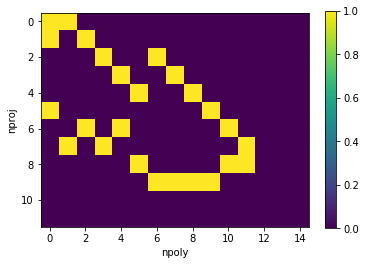

In [8]:
plt.imshow(X_train[149])
plt.colorbar()
plt.xlabel('npoly')
plt.ylabel('nproj')
plt.savefig('cicy150.pdf')

### A simple Dense model

Define some training parameters, such as numclasses bSize, ...

In [9]:
num_classes = np.max(df['H11'].values)
bsize = 32
nEpochs = 50
validation_data = (X_test, y_test)

write a function that gives us a fully connected model depending on a set of hyper parameters

In [10]:
def make_model(act = 'tanh', nHidden = 128, nLayer = 3, lreg = 0,
               dropout = 0, lr = 0.001, name = 'm1'):
    reg = tfk.regularizers.L1L2(l1=lreg, l2=lreg)
    model = tfk.Sequential()
    model.add(tfk.Input(shape=cicylist.shape[1:], name=name+'Input'))
    model.add(tfk.layers.Flatten(name=name+"flatten"))
    for i in range(nLayer):
        model.add(tfk.layers.Dense(nHidden, activation = act, kernel_regularizer = reg, name = name+'layer'+str(i)))
        if dropout > 0:
            model.add(tfk.layers.Dropout(dropout, name=name+'dropout'+str(i)))
    model.add(tfk.layers.Dense(num_classes, activation="softmax", name=name+"output"))
    model.compile(optimizer=tfk.optimizers.SGD(learning_rate=lr, momentum=0.99), 
                    loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    return model

make the model

In [11]:
model1 = make_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1flatten (Flatten)          (None, 180)               0         
_________________________________________________________________
m1layer0 (Dense)             (None, 128)               23168     
_________________________________________________________________
m1layer1 (Dense)             (None, 128)               16512     
_________________________________________________________________
m1layer2 (Dense)             (None, 128)               16512     
_________________________________________________________________
m1output (Dense)             (None, 19)                2451      
Total params: 58,643
Trainable params: 58,643
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model1.fit(X_train, y_train, validation_data=validation_data, batch_size=bsize, epochs=nEpochs)

Epoch 1/50
198/198 [==============================] - 0s 2ms/step - loss: 1.8487 - accuracy: 0.4197 - val_loss: 1.3630 - val_accuracy: 0.6152
Epoch 2/50
198/198 [==============================] - 0s 1ms/step - loss: 1.2335 - accuracy: 0.6050 - val_loss: 1.1633 - val_accuracy: 0.6392
Epoch 3/50
198/198 [==============================] - 0s 1ms/step - loss: 1.0996 - accuracy: 0.6468 - val_loss: 1.1527 - val_accuracy: 0.6101
Epoch 4/50
198/198 [==============================] - 0s 1ms/step - loss: 1.0235 - accuracy: 0.6643 - val_loss: 1.0635 - val_accuracy: 0.6709
Epoch 5/50
198/198 [==============================] - 0s 1ms/step - loss: 0.9450 - accuracy: 0.6871 - val_loss: 0.9865 - val_accuracy: 0.6816
Epoch 6/50
198/198 [==============================] - 0s 1ms/step - loss: 0.9038 - accuracy: 0.7007 - val_loss: 0.9564 - val_accuracy: 0.6943
Epoch 7/50
198/198 [==============================] - 0s 1ms/step - loss: 0.8556 - accuracy: 0.7163 - val_loss: 0.9139 - val_accuracy: 0.7019
Epoch 

Plot accuracy and loss

In [13]:
def make_plot(history, fname = ''):
    fig = plt.figure(figsize=[15,7])
    ax1 = plt.subplot(121)
    ax1.plot(history['accuracy'], color='blue', label='train')
    ax1.plot(history['val_accuracy'], color='red', label='val')
    ax1.legend(loc='best')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax2 = plt.subplot(122)
    ax2.plot(history['loss'], color='blue', label='train')
    ax2.plot(history['val_loss'], color='red', label='val')
    ax2.legend(loc='best')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    if fname != '':
        plt.savefig(fname)
    #return fig

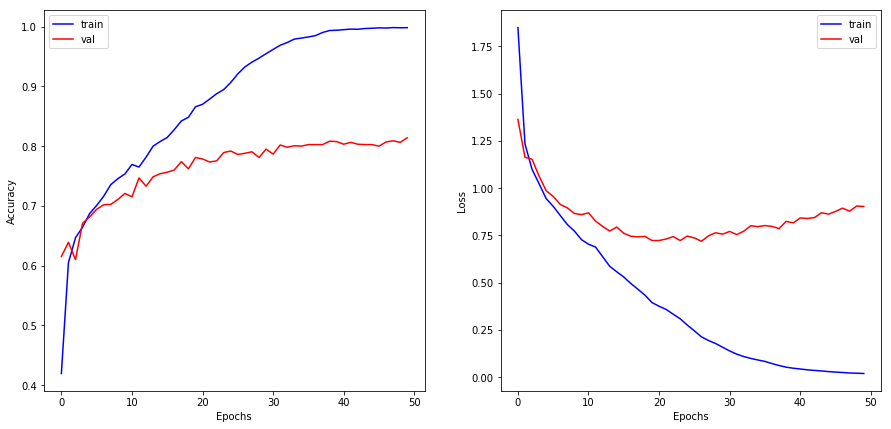

In [14]:
make_plot(history.history, fname='cicy_no_reg.pdf')

We are overfitting. Let's introduce some L1 and L2 regularisation.

In [15]:
model2 = make_model(lreg=0.001, name='l12')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
l12flatten (Flatten)         (None, 180)               0         
_________________________________________________________________
l12layer0 (Dense)            (None, 128)               23168     
_________________________________________________________________
l12layer1 (Dense)            (None, 128)               16512     
_________________________________________________________________
l12layer2 (Dense)            (None, 128)               16512     
_________________________________________________________________
l12output (Dense)            (None, 19)                2451      
Total params: 58,643
Trainable params: 58,643
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model2.fit(X_train, y_train, validation_data=validation_data, batch_size=bsize, epochs=nEpochs)

Epoch 1/50
198/198 [==============================] - 0s 2ms/step - loss: 6.0823 - accuracy: 0.4235 - val_loss: 5.2435 - val_accuracy: 0.5608
Epoch 2/50
198/198 [==============================] - 0s 1ms/step - loss: 4.5873 - accuracy: 0.5966 - val_loss: 4.0218 - val_accuracy: 0.6266
Epoch 3/50
198/198 [==============================] - 0s 1ms/step - loss: 3.5250 - accuracy: 0.6294 - val_loss: 3.1123 - val_accuracy: 0.6361
Epoch 4/50
198/198 [==============================] - 0s 1ms/step - loss: 2.7786 - accuracy: 0.6295 - val_loss: 2.4970 - val_accuracy: 0.6342
Epoch 5/50
198/198 [==============================] - 0s 1ms/step - loss: 2.2812 - accuracy: 0.6270 - val_loss: 2.1417 - val_accuracy: 0.6108
Epoch 6/50
198/198 [==============================] - 0s 1ms/step - loss: 1.9723 - accuracy: 0.6257 - val_loss: 1.9187 - val_accuracy: 0.6253
Epoch 7/50
198/198 [==============================] - 0s 1ms/step - loss: 1.7805 - accuracy: 0.6286 - val_loss: 1.7272 - val_accuracy: 0.6253
Epoch 

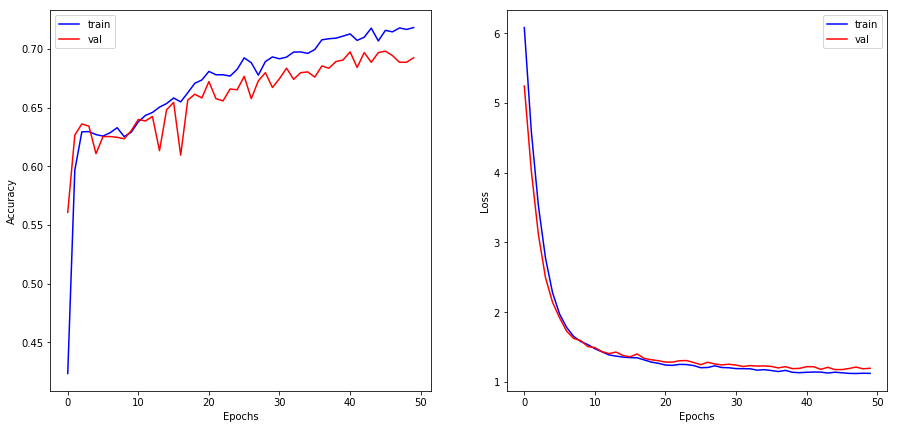

In [17]:
make_plot(history.history, fname='cicy_l1l2_reg.pdf')

Finally try some dropout

In [18]:
model3 = make_model(dropout=0.2, name='d1')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d1flatten (Flatten)          (None, 180)               0         
_________________________________________________________________
d1layer0 (Dense)             (None, 128)               23168     
_________________________________________________________________
d1dropout0 (Dropout)         (None, 128)               0         
_________________________________________________________________
d1layer1 (Dense)             (None, 128)               16512     
_________________________________________________________________
d1dropout1 (Dropout)         (None, 128)               0         
_________________________________________________________________
d1layer2 (Dense)             (None, 128)               16512     
_________________________________________________________________
d1dropout2 (Dropout)         (None, 128)              

In [19]:
history = model3.fit(X_train, y_train, validation_data=validation_data, batch_size=bsize, epochs=nEpochs)

Epoch 1/50
198/198 [==============================] - 0s 2ms/step - loss: 1.9038 - accuracy: 0.3741 - val_loss: 1.3925 - val_accuracy: 0.5772
Epoch 2/50
198/198 [==============================] - 0s 1ms/step - loss: 1.3343 - accuracy: 0.5689 - val_loss: 1.2173 - val_accuracy: 0.6127
Epoch 3/50
198/198 [==============================] - 0s 1ms/step - loss: 1.2005 - accuracy: 0.6154 - val_loss: 1.1442 - val_accuracy: 0.6386
Epoch 4/50
198/198 [==============================] - 0s 1ms/step - loss: 1.1203 - accuracy: 0.6409 - val_loss: 1.0715 - val_accuracy: 0.6532
Epoch 5/50
198/198 [==============================] - 0s 1ms/step - loss: 1.0862 - accuracy: 0.6431 - val_loss: 1.0606 - val_accuracy: 0.6633
Epoch 6/50
198/198 [==============================] - 0s 1ms/step - loss: 1.0577 - accuracy: 0.6555 - val_loss: 1.0379 - val_accuracy: 0.6665
Epoch 7/50
198/198 [==============================] - 0s 1ms/step - loss: 1.0259 - accuracy: 0.6693 - val_loss: 1.0052 - val_accuracy: 0.6867
Epoch 

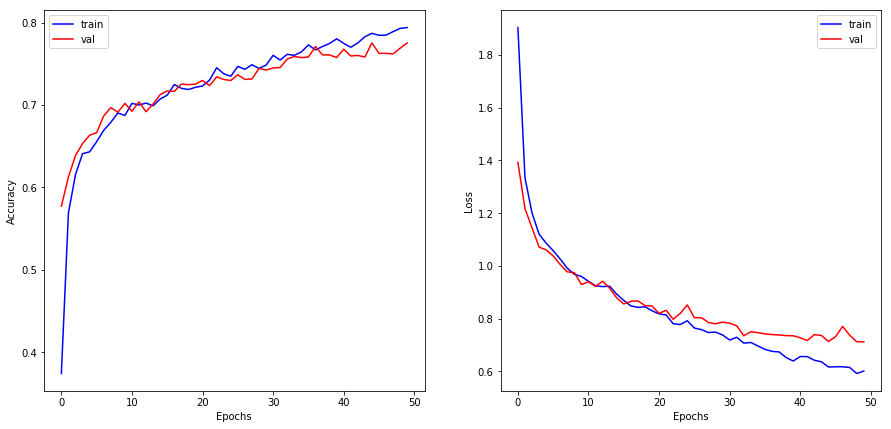

In [20]:
make_plot(history.history, fname='cicy_dropout.pdf')

### Inception model

The best performing model is based on the more modern inception architectures. 

 - train, test: 1:3
 - accuracy: 97.6%
    
Can we reproduce this?

In [21]:
from tensorflow.python.keras.engine import training

In [22]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', 
                  strides=(1,1), name='None', l1 = 0.0001, l2 = 0.001):
    x = tfk.layers.Conv2D(filters, (num_row, num_col), strides=strides,
                         padding=padding, use_bias=False, name=name+'_conv',
                         kernel_regularizer=tfk.regularizers.l1_l2(l1=l1, l2=l2))(x)
    x = tfk.layers.BatchNormalization(axis=-1, scale=False, name=name+'_bn')(x)
    x = tfk.layers.Activation('relu', name=name)(x)
    return x

In [23]:
def inception_model(input_shape, nunits, lreg, nDense, nBlock, num_classes, lr, momentum):
    inputs = tfk.layers.Input(shape = input_shape, name='input')
    x = inputs
    for i in range(nBlock):
        branch12x1 = conv2d_bn(x, nunits[i], 12, 1, l1=lreg[0], l2=lreg[1], name = 'b'+str(i)+'_12x1')
        branch1x15 = conv2d_bn(x, nunits[i], 1, 15, l1=lreg[0], l2=lreg[1], name = 'b'+str(i)+'_1x15')
        x = tfk.layers.concatenate([branch12x1, branch1x15], axis=-1, name='block'+str(i))

    x = tfk.layers.Dropout(rate=0.2, name='dropout')(x)
    x = tfk.layers.Flatten(name='flatten')(x)
    for i in range(nDense):
        x = tfk.layers.Dense(nunits[nBlock-1+i], activation='relu', name='dense'+str(i),
                            kernel_regularizer=tfk.regularizers.l1_l2(l1=lreg[0], l2=lreg[1]))(x)

    if num_classes > 1:
        #classification
        x = tfk.layers.Dense(num_classes, activation='softmax', name='prediction',
                            kernel_regularizer=tfk.regularizers.l1_l2(l1=lreg[0], l2=lreg[1]))(x)
    else:
        #regression
        x = tfk.layers.Dense(1, name='prediction',
                            kernel_regularizer=tfk.regularizers.l1_l2(l1=lreg[0], l2=lreg[1]))(x)

    model = training.Model(inputs, x, name='inception')
    #model.build(input_shape)
    optimizer = tfk.optimizers.SGD(lr = lr, momentum = momentum)
    
    if num_classes > 1:
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    else:
        model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mean_squared_error"])
    model.summary()
    return model

In [24]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

hyperparameters are taken from [2007.13379](https://arxiv.org/pdf/2007.13379.pdf)

In [25]:
input_shape = (12,15,1)
units = [32,64,32]
lreg = [0.0001, 0.001]
lr = 0.0001
momentum = 0.99
imodel = inception_model(input_shape, units, lreg, 0, len(units), num_classes, lr, momentum)

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 12, 15, 1)]  0                                            
__________________________________________________________________________________________________
b0_12x1_conv (Conv2D)           (None, 12, 15, 32)   384         input[0][0]                      
__________________________________________________________________________________________________
b0_1x15_conv (Conv2D)           (None, 12, 15, 32)   480         input[0][0]                      
__________________________________________________________________________________________________
b0_12x1_bn (BatchNormalization) (None, 12, 15, 32)   96          b0_12x1_conv[0][0]               
__________________________________________________________________________________________

In [26]:
xdata = np.expand_dims(cicylist, axis=-1)
ydata = one_hot_h11#h11
X_train, X_test, y_train, y_test = train_test_split(
        xdata, ydata, test_size=0.65, random_state=42)
validation_data = (X_test, y_test)

bsize = 32
nEpochs = 20
history = imodel.fit(X_train, y_train, validation_data=validation_data,
              batch_size=bsize, epochs=nEpochs, callbacks=[callback])

Epoch 1/20
87/87 [==============================] - 9s 107ms/step - loss: 3.2841 - accuracy: 0.4048 - val_loss: 3.3058 - val_accuracy: 0.2002
Epoch 2/20
87/87 [==============================] - 8s 94ms/step - loss: 2.3760 - accuracy: 0.6302 - val_loss: 3.1195 - val_accuracy: 0.1998
Epoch 3/20
87/87 [==============================] - 8s 95ms/step - loss: 2.0601 - accuracy: 0.6910 - val_loss: 3.0868 - val_accuracy: 0.3387
Epoch 4/20
87/87 [==============================] - 8s 96ms/step - loss: 1.8534 - accuracy: 0.7377 - val_loss: 2.7506 - val_accuracy: 0.5242
Epoch 5/20
87/87 [==============================] - 8s 96ms/step - loss: 1.6227 - accuracy: 0.8263 - val_loss: 2.4248 - val_accuracy: 0.6271
Epoch 6/20
87/87 [==============================] - 8s 96ms/step - loss: 1.5020 - accuracy: 0.8770 - val_loss: 2.2662 - val_accuracy: 0.6588
Epoch 7/20
87/87 [==============================] - 8s 96ms/step - loss: 1.4494 - accuracy: 0.8933 - val_loss: 2.0306 - val_accuracy: 0.7120
Epoch 8/20
8

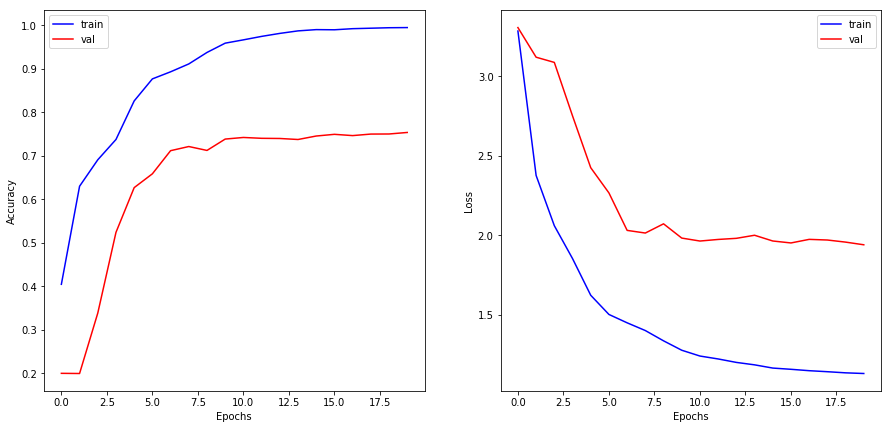

In [27]:
make_plot(history.history, fname='cicy_inception.pdf')

What about regression?

In [28]:
model_reg = inception_model(input_shape, units, lreg, 0, len(units), -1, lr, momentum)

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 12, 15, 1)]  0                                            
__________________________________________________________________________________________________
b0_12x1_conv (Conv2D)           (None, 12, 15, 32)   384         input[0][0]                      
__________________________________________________________________________________________________
b0_1x15_conv (Conv2D)           (None, 12, 15, 32)   480         input[0][0]                      
__________________________________________________________________________________________________
b0_12x1_bn (BatchNormalization) (None, 12, 15, 32)   96          b0_12x1_conv[0][0]               
__________________________________________________________________________________________

In [29]:
ydata = h11
X_train, X_test, y_train, y_test = train_test_split(
        xdata, ydata, test_size=0.65, random_state=42)
validation_data = (X_test, y_test)
model_reg.fit(X_train, y_train, validation_data=validation_data,
              batch_size=bsize, epochs=nEpochs, callbacks=[callback])

Epoch 1/20
87/87 [==============================] - 8s 95ms/step - loss: 25.3979 - mean_squared_error: 24.5050 - val_loss: 40.4031 - val_mean_squared_error: 39.4639
Epoch 2/20
87/87 [==============================] - 8s 94ms/step - loss: 7.1456 - mean_squared_error: 6.1441 - val_loss: 49.4222 - val_mean_squared_error: 48.3598
Epoch 3/20
87/87 [==============================] - 8s 97ms/step - loss: 4.2990 - mean_squared_error: 3.1938 - val_loss: 20.9906 - val_mean_squared_error: 19.8495
Epoch 4/20
87/87 [==============================] - 8s 95ms/step - loss: 3.5655 - mean_squared_error: 2.4039 - val_loss: 7.9915 - val_mean_squared_error: 6.8136
Epoch 5/20
87/87 [==============================] - 8s 95ms/step - loss: 2.8727 - mean_squared_error: 1.6866 - val_loss: 3.7183 - val_mean_squared_error: 2.5261
Epoch 6/20
87/87 [==============================] - 8s 97ms/step - loss: 2.7155 - mean_squared_error: 1.5210 - val_loss: 2.7777 - val_mean_squared_error: 1.5818
Epoch 7/20
87/87 [========

Let's compute the accuracy of this regresion model

In [30]:
np.sum(np.abs(np.round(model_reg.predict(X_test)-np.expand_dims(y_test, axis=-1))) == 0)/len(y_test)

0.589873417721519

Discrepancy to the paper can be explained with only 20 Epochs training time and a different learning rate decay schedule. They also added their batch normalization after concat, which is non standard I think, but maybe gives better accuracy in this setting.

## Exercises

Pen and Paper:
1. Reproduce equation (3) from the slides. The bias variance trade off.

Machine learning:
1. Play around with the hyperparameters of the fully connected Neural Network. Can you get more than 80% validation accurcay?
2. What happens when you increase the test/validation percentage?
3. Any ideas in general of what to do, when the training data is small?

Physics:
1. Reproduce the test accuracy of 2007.13379. Implement the correct learning rate decay. Train for >1000 Epochs.
2. What about Calabi Yau 4-folds? Can you learn these? (Hint: Yes, even the more difficult $h^{3,1}$ is learnable using the Inception architecture.)